In [20]:
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from scipy.stats import ttest_ind

games_df= pd.read_csv("./raw_data/games.csv")
gps_df= pd.read_csv("./raw_data/gps.csv")

gps_df['Longitude'] = gps_df.groupby('PlayerID')['Longitude'].fillna(method='ffill')
print(games_df.columns)
print(gps_df.columns)

Index(['GameID', 'Date', 'Tournament', 'TournamentGame', 'Team', 'Opponent',
       'Outcome', 'TeamPoints', 'TeamPointsAllowed'],
      dtype='object')
Index(['GameID', 'Half', 'PlayerID', 'FrameID', 'Time', 'GameClock', 'Speed',
       'AccelImpulse', 'AccelLoad', 'AccelX', 'AccelY', 'AccelZ', 'Longitude',
       'Latitude'],
      dtype='object')


In [2]:
# Remove the data that logitude was nan for a player and could not
# be filled based on the previous frames
print(len(gps_df) - gps_df['Longitude'].count())
gps_df.dropna(inplace = True)
print(len(gps_df))

7
4570153


In [24]:
gps_df['GameClock'] = pd.to_datetime(gps_df.GameClock, format = '%H:%M:%S')
gps_df['GameClockInSeconds'] = gps_df.GameClock.dt.hour * 3600 + gps_df.GameClock.dt.minute * 60 + gps_df.GameClock.dt.second


Merging the gpa data with game data to get the dates. We kept the team points and game outcome as well. 

In [25]:
gps_df = gps_df[ (gps_df['PlayerID'] < 18) ]

gps_with_date = gps_df.merge(games_df[['GameID', 'Date', 'TeamPoints','Outcome']],
                    how='inner', on='GameID').drop_duplicates()
gps_with_date.head()

,GameID,Half,PlayerID,FrameID,Time,GameClock,Speed,AccelImpulse,AccelLoad,AccelX,AccelY,AccelZ,Longitude,Latitude,GameClockInSeconds,Date,TeamPoints,Outcome
0,1,1,2,1,1900-01-01 00:22:01,1900-01-01,0.658334,0.611112,0.005330,0.13250,0.69875,0.56500,55.466666,24.994873,0,2017-11-30,19,W
1,1,1,2,2,1900-01-01 00:22:01,1900-01-01,0.594445,0.638889,0.006568,0.11125,0.92000,0.70625,55.466666,24.994874,0,2017-11-30,19,W
2,1,1,2,3,1900-01-01 00:22:01,1900-01-01,0.363889,2.305557,0.003114,0.01375,0.77000,0.67750,55.466667,24.994874,0,2017-11-30,19,W
3,1,1,2,4,1900-01-01 00:22:01,1900-01-01,0.444445,0.805556,0.002602,0.00625,0.88625,0.59500,55.466667,24.994874,0,2017-11-30,19,W
4,1,1,2,5,1900-01-01 00:22:01,1900-01-01,0.400000,0.444445,0.003813,-0.01750,0.85750,0.57375,55.466668,24.994874,0,2017-11-30,19,W


In [11]:
gps_with_date = gps_with_date[(gps_with_date['AccelX'] >= 0)]

accel_data = gps_with_date.copy()
accel_data[['MaxAccImpulse', 'MaxAccLoad']] = gps_with_date.groupby(['GameID','PlayerID'])['AccelImpulse', 'AccelLoad'].transform('max')
accel_data.head()

,GameID,Half,PlayerID,FrameID,Time,GameClock,Speed,AccelImpulse,AccelLoad,AccelX,...,AccelZ,Longitude,Latitude,TimeInSeconds,GameClockInSeconds,Date,TeamPoints,Outcome,MaxAccImpulse,MaxAccLoad
0,1,1,2,1,1900-01-01 00:22:01,1900-01-01 00:00:00,0.658334,0.611112,0.005330,0.13250,...,0.56500,55.466666,24.994873,1321,0,2017-11-30,19,W,5.972227,0.668839
1,1,1,2,2,1900-01-01 00:22:01,1900-01-01 00:00:00,0.594445,0.638889,0.006568,0.11125,...,0.70625,55.466666,24.994874,1321,0,2017-11-30,19,W,5.972227,0.668839
2,1,1,2,3,1900-01-01 00:22:01,1900-01-01 00:00:00,0.363889,2.305557,0.003114,0.01375,...,0.67750,55.466667,24.994874,1321,0,2017-11-30,19,W,5.972227,0.668839
3,1,1,2,4,1900-01-01 00:22:01,1900-01-01 00:00:00,0.444445,0.805556,0.002602,0.00625,...,0.59500,55.466667,24.994874,1321,0,2017-11-30,19,W,5.972227,0.668839
14,1,1,2,15,1900-01-01 00:22:02,1900-01-01 00:00:01,0.341667,0.305556,0.001518,0.05750,...,0.61125,55.466669,24.994872,1322,1,2017-11-30,19,W,5.972227,0.668839


In [12]:
second_data = gps_with_date.groupby(['Date','GameID','Outcome','TeamPoints',
                                     'PlayerID','Half','GameClockInSeconds'],
                                    as_index = False)[['Speed','AccelImpulse',
                                                       'AccelLoad', 'AccelX']].mean()

second_data.head()

,Date,GameID,Outcome,TeamPoints,PlayerID,Half,GameClockInSeconds,Speed,AccelImpulse,AccelLoad,AccelX
0,2017-11-30,1,W,19,2,1,0,0.515278,1.090279,0.004404,0.065937
1,2017-11-30,1,W,19,2,1,1,0.178472,1.083334,0.003158,0.085625
2,2017-11-30,1,W,19,2,1,2,0.000000,0.000000,0.003979,0.259821
3,2017-11-30,1,W,19,2,1,3,0.000000,0.000000,0.006544,0.135312
4,2017-11-30,1,W,19,2,1,4,0.061574,0.615741,0.008943,0.068125


In [13]:
second_data['MaxSpeedInGame'] = second_data.groupby(['GameID','PlayerID'])['Speed'].transform(max)
second_data['MaxAccelImpulseInGame'] = second_data.groupby(['GameID','PlayerID'])['AccelImpulse'].transform(max)
second_data['MaxAccelLoadInGame'] = second_data.groupby(['GameID','PlayerID'])['AccelLoad'].transform(max)
second_data['MaxAccelXInGame'] = second_data.groupby(['GameID','PlayerID'])['AccelX'].transform(max)
second_data.head()

,Date,GameID,Outcome,TeamPoints,PlayerID,Half,GameClockInSeconds,Speed,AccelImpulse,AccelLoad,AccelX,MaxSpeedInGame,MaxAccelImpulseInGame,MaxAccelLoadInGame,MaxAccelXInGame
0,2017-11-30,1,W,19,2,1,0,0.515278,1.090279,0.004404,0.065937,7.284728,4.423615,0.199058,1.270156
1,2017-11-30,1,W,19,2,1,1,0.178472,1.083334,0.003158,0.085625,7.284728,4.423615,0.199058,1.270156
2,2017-11-30,1,W,19,2,1,2,0.000000,0.000000,0.003979,0.259821,7.284728,4.423615,0.199058,1.270156
3,2017-11-30,1,W,19,2,1,3,0.000000,0.000000,0.006544,0.135312,7.284728,4.423615,0.199058,1.270156
4,2017-11-30,1,W,19,2,1,4,0.061574,0.615741,0.008943,0.068125,7.284728,4.423615,0.199058,1.270156


In [31]:
idx = second_data['MaxSpeedInGame'] == second_data['Speed']
second_data[idx]['Half'].value_counts()

2    223
1    220
Name: Half, dtype: int64

In [27]:
second_data[idx].groupby('PlayerID')['Half'].value_counts()

PlayerID  Half
1         1       16
          2       12
2         2       29
          1        9
3         2       14
          1       12
4         1       21
          2       16
5         2       17
          1       11
6         2        5
7         1       25
          2        9
8         1       25
          2        9
9         1        5
          2        5
10        2       15
          1       11
11        1       23
          2       15
12        1       16
          2       12
13        2       26
          1       12
14        2       11
          1        7
15        1       14
          2        7
16        2       16
          1       12
17        2        5
          1        1
Name: Half, dtype: int64

In [28]:
second_data[idx].groupby('PlayerID')['GameID'].unique()

PlayerID
1     [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 2...
2     [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
3     [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
4     [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
5     [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 2...
6                                       [1, 2, 3, 4, 5]
7     [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
8     [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
9                       [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
10    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
11    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
12    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
13    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
14    [4, 6, 7, 8, 9, 10, 15, 16, 17, 18, 29, 30, 31...
15    [4, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29...
16    [4, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21...
17                                   [1, 2, 3, 4, 5, 6]
Name: GameID, dtype: object

In [29]:
second_data[idx].groupby('PlayerID')['GameID'].nunique()

PlayerID
1     28
2     38
3     26
4     37
5     28
6      5
7     34
8     34
9     10
10    26
11    38
12    28
13    38
14    18
15    21
16    28
17     6
Name: GameID, dtype: int64

In general maximum speed can happen either in first half or second half. For some players we can see that their max speed occurs in the second half across all games more than the first half and for some other players we can see a reverse pattern.<br>
Also, after printing out the gameIDs that each player participated in, we can see that the regular players that played in almost all games are the following players: (2,4,7,8,10,11,13)

SessionType  Combat  Conditioning  Game  Mobility/Recovery  Skills  Speed  \
PlayerID                                                                    
1                 6            57    22                 42     134     78   
2                22            58    19                 81     124     77   
3                 2            76    26                 49     102     83   
4                 6            46    32                 25     105     78   
5                 4            43    14                 23      36     43   

SessionType  Strength  
PlayerID               
1                 133  
2                 112  
3                 139  
4                 116  
5                  82  


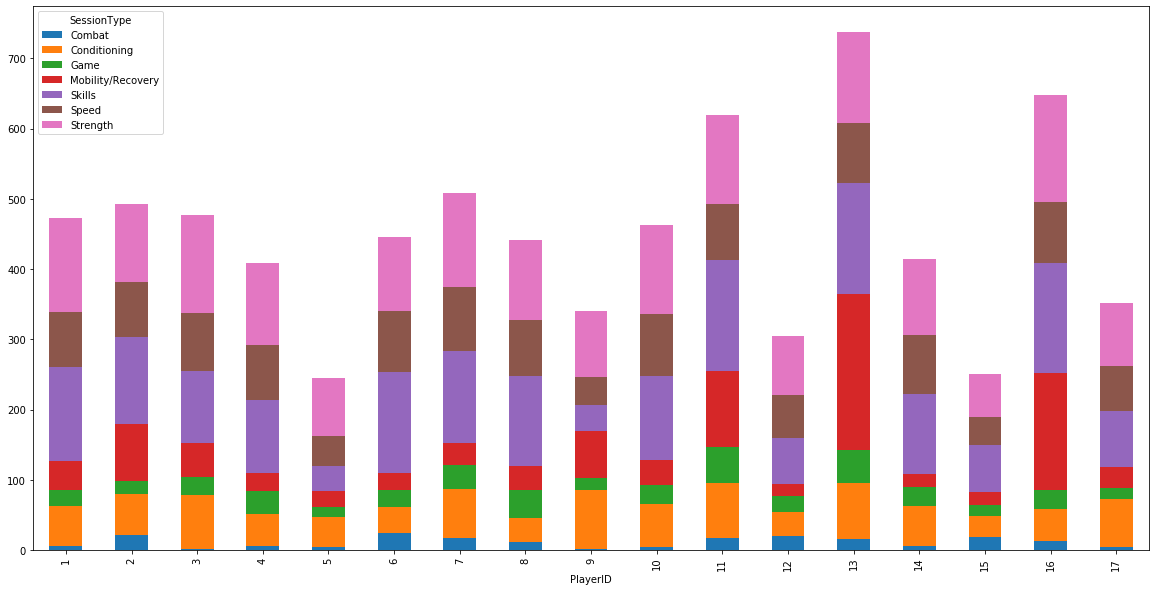

In [41]:
processed_rpe_df = pd.read_csv("./processed_data/processed_rpe.csv")
training_yes = processed_rpe_df[processed_rpe_df['Training'] == 1].drop(['Training'], axis=1)
session_type_by_player_id = training_yes.groupby(['PlayerID', 'SessionType'])['Date'].count().unstack('SessionType').fillna(0)
print(session_type_by_player_id.head())
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(111)
session_type_by_player_id.plot(ax=ax1, kind='bar', stacked=True)
plt.show()


In [42]:
speed_data = second_data[['Date','GameID','Outcome','TeamPoints','PlayerID','MaxSpeedInGame','MaxAccelImpulseInGame']].drop_duplicates()
speed_data.to_csv('./processed_data/processed_gps.csv')
speed_data = speed_data.sort_values(by=['PlayerID', 'Date'])


Index(['Date', 'GameID', 'Outcome', 'TeamPoints', 'PlayerID', 'MaxSpeedInGame',
       'MaxAccelImpulseInGame'],
      dtype='object')
Max speed average
6.935746684112912
6.603067102702249
max accel average
4.903149061781086
4.869268961193322


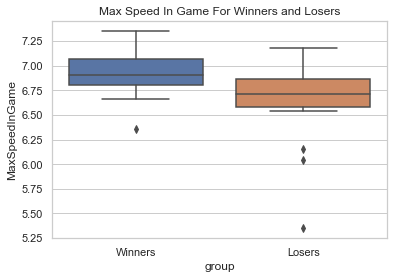

p-value is: 0.0050  t-statistic is: 2.99


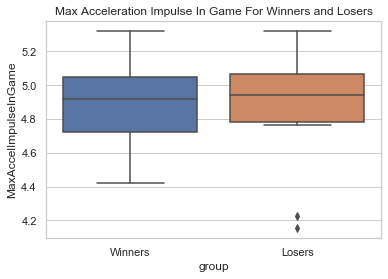

p-value is: 0.7061  t-statistic is: 0.38


In [48]:
def box_plot_and_ttest(group1_name, group2_name, column1, column2, ylabel, title):
    plt.figure()
    sns.set(context='notebook', style='whitegrid')
    sns.utils.axlabel(xlabel="group", ylabel=ylabel)
    sns.boxplot(data=[column1, column2])
    plt.xticks(plt.xticks()[0], [group1_name, group2_name])
    plt.title(title)
    plt.show()
    t, p = ttest_ind(column1, column2)
    print("p-value is: %.4f" % p," t-statistic is: %.2f" % t)
    
    
print(speed_data.columns)
avg_speed_per_game = speed_data[['GameID','Outcome','TeamPoints','MaxSpeedInGame','MaxAccelImpulseInGame']].groupby(['GameID','Outcome','TeamPoints'],as_index=False).mean()
winners = avg_speed_per_game[avg_speed_per_game['Outcome'] == 'W']
losers = avg_speed_per_game[avg_speed_per_game['Outcome'] == 'L']

print('Max speed average')
print(winners['MaxSpeedInGame'].mean())
print(losers['MaxSpeedInGame'].mean())
print('max accel average')
print(winners['MaxAccelImpulseInGame'].mean())
print(losers['MaxAccelImpulseInGame'].mean())

box_plot_and_ttest('Winners', 'Losers', winners['MaxSpeedInGame'], losers['MaxSpeedInGame'], 'MaxSpeedInGame', 'Max Speed In Game For Winners and Losers')
box_plot_and_ttest('Winners', 'Losers', winners['MaxAccelImpulseInGame'], losers['MaxAccelImpulseInGame'], 'MaxAccelImpulseInGame', 'Max Acceleration Impulse In Game For Winners and Losers')